In [37]:
import numpy as np
from cosmoTransitions.tunneling1D import SingleFieldInstanton
from cosmoTransitions import generic_potential
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special
import seaborn as sns
from scipy import misc
from scipy.special import hyp2f1



%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size

label_size=20
thick_size=20


####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
gtab = np.loadtxt( 'standardmodel2018.txt' )[::20]
g_star=interpolate.interp1d(gtab[::,0], gtab[::,1], kind='cubic')
g_sstar=interpolate.interp1d(gtab[::,0], gtab[::,3], kind='cubic')


###MY FUNCTIONS START HERE      
def Hubble_radiation(T):
    """Hubble rate (squared) coming from radiation dof"""
    num_dof=g_star(T)
    Hubble_rad_squared=num_dof*np.pi**2/90*T**4/Mplanck**2
    return Hubble_rad_squared

def Gamma_Hubble4(S,T):
    """Nucleation probability per Hubble volume, including matter contribution. 
    Integrand in formula (2.2) 1809.08242 """
    Gamma1=T**4*np.exp(-S/T)*np.sqrt((S/2/np.pi/T))**(3)
    return Gamma1


def GBpotential(z,**coeffs):
    Ngb=coeffs["Ngb"]
    lam=(Ngb-1)/2
    pot=0
    for n,a in coeffs["na_coeffs"]:
        pot+=a*hyp2f1(-n/2,n/2+lam,lam+1/2,z**2)
    return pot

def findZeros(potential,**args):
    print(args)
    return
    fun=lambda z :potential(z,**args)
    return fun(.3)
    Dfun=lambda z :misc.derivative(fun, x0=z, dx=1e-0, n=1)
    D2fun=lambda z :misc.derivative(fun, x0=z, dx=1e-0, n=2)
    sols=[]
    for i in np.linspace(0,1,30):
        #sol=optimize.fmin(Dfun, x0=i,disp=False,ftol=1e-25)
        sol=optimize.root(Dfun, x0=i)
        #sol=optimize.root(Dfun, [i], jac=Dfun, method='hybr')
        if sol.x<0 or D2fun(sol.x)<0:
            continue
        sols.append(np.round(sol.x,4))
        
    return np.unique(sols)






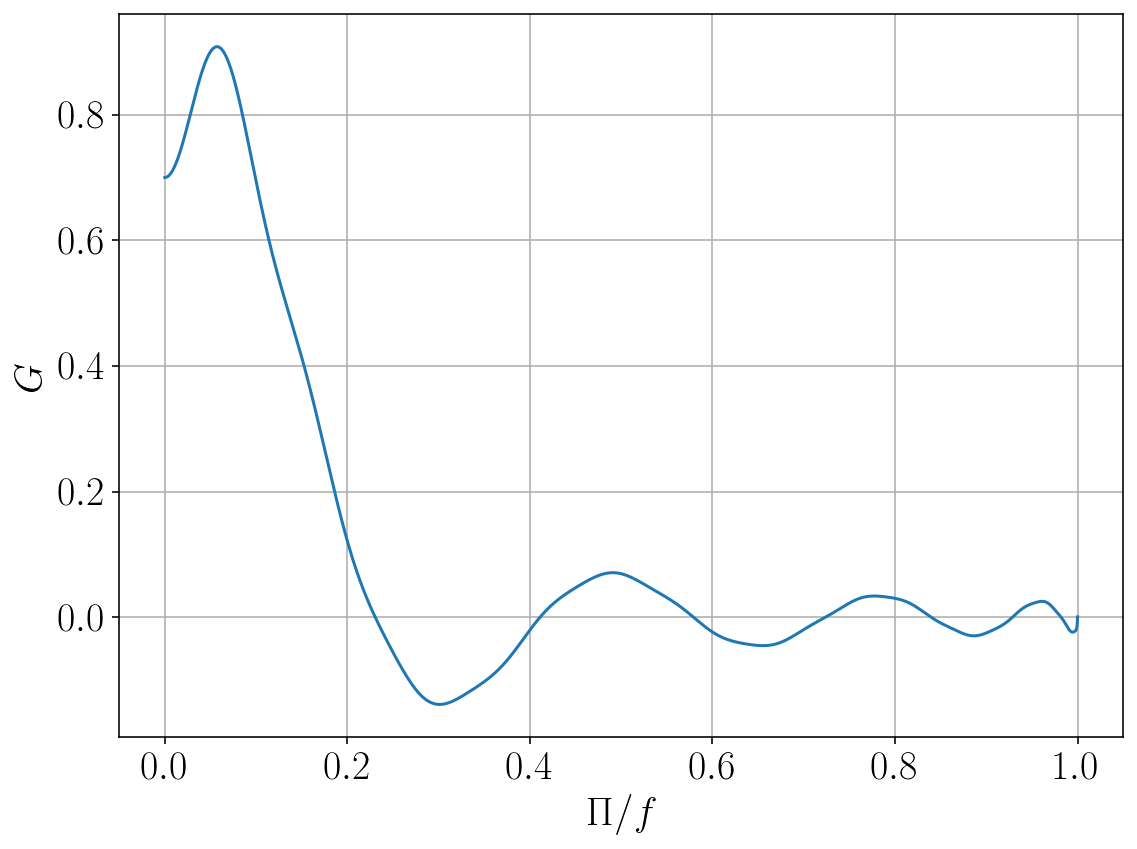

In [44]:
myargs={"Ngb":4,"na_coeffs":[(15,1),(70,-.3)]}

z_range=np.linspace(0,1,2000)
#zeros_list=findZeros(Ngb,n)
plt.plot(z_range,GBpotential(z_range,**myargs))

plt.xlabel("$\Pi/f$",size=label_size)
plt.ylabel("$G$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
# #mytitle=str(round(df_full.lams.min(),2))+"$< \\lambda_{s} <$"+str(round(df_full.lams.max(),2))
# #plt.title(mytitle,size=label_size)
plt.tight_layout()
# #plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
plt.show()

In [2]:
class model1(generic_potential.generic_potential):

    def init(self, GBconstants):
        self.Ndim = 1
        self.Ngb=GBconstants["Ngb"]
        
        z_range=np.linspace(0,1,2000)
        pot_vals=GBpotential(z_range,**GBconstants)
        self.pot_fun=interpolate.interp1d(z_range, pot_vals,fill_value="extrapolate")
        
    def plot1(self):
        z_range=np.linspace(0,1,2000)
        plt.plot(z_range,self.pot_fun(z_range))

        plt.xlabel("$\Pi/f$",size=label_size)
        plt.ylabel("$G$",size=label_size)
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        # #mytitle=str(round(df_full.lams.min(),2))+"$< \\lambda_{s} <$"+str(round(df_full.lams.max(),2))
        # #plt.title(mytitle,size=label_size)
        plt.tight_layout()
        # #plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
        plt.show()
    
 
    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])

    def V0(self, X):
        X = np.asanyarray(X)
        h = X[...]
        z=h/self.f
        pot =self.const*GBpotential(self.Ngb,self.n,z)
        
        return pot
    
       
    
    def boson_massSq(self, X, T):
        X = np.asanyarray(X)
        h = X[...,]
        
        ##Determine normalization constant
        fun=lambda x :self.V0(x)
        DG=misc.derivative(fun, x0=h, dx=1e-2, n=1,order=5)
        D2G=misc.derivative(fun, x0=h, dx=1e-2, n=2,order=5)

        Mh2=(-h*DG+(self.f**2-h**2)*D2G)/self.f**2
        MG2=(self.f**2-h**2)*DG/self.f**2/(h)

        M = np.array([Mh2,MG2])
        M = np.rollaxis(M, 0, len(M.shape))


        dof = np.array([1,self.Ngb-1])

        c = np.array([.5,.5])

        return M, dof, c
    
    def fermion_massSq(self, X):
        X = np.asanyarray(X)
        h = X[...,]

        mt=1**2*h**2/2
        M = np.array([mt])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.
        dof = 0*np.array([12])
        return M, dof
    
    def approxZeroTMin(self):
        return [np.array(v),]
    
